# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

In [ ]:
import pickle,sys,os
import pathlib

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.decompose_feedback import decompose_real_time_feedback
from analysis_tools.preprocess import get_preprocessed_data_from_df

# Except subjects for predictors :
problematic_subjects_misc = ["611d60c383f4f70ff4bc99fd", # S2 : Did the task twice 
                             "66a74bdfdcaccdc0703894d5", # Consent revoked 
                            "667d92f2ea5c1542f417285d",
                            "6548f570022275786186ffbd"]
                
                

# problematic_subjects_fraudulent =["66bb5c09526e6d80f1146800"]
                # This subject had "eclectic performances" so say the least
                # Left fullscreen twice and missed 4 actions


# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "003"
# Study 2 : the std of the was 0.025,0.1 and 0.175
PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = []
for prolific_study_id in PROLIFIC_STUDY_IDs:
    task_results = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,prolific_study_id,
                                                              process_feedback_data_stream=True,override_save=False)
    print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
    TASK_RESULTS_ALL += task_results
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")



# What were all the studies for task 003 ?
INTERNAL_TASK_ID = "003"
# Study 2 : the std of the was 0.025,0.1 and 0.175
# PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,None,
                                                            process_feedback_data_stream=True,override_save=False)
print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)
TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")


all_task_codes = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["task_code"].split("+")[1]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)
print(all_task_codes)

 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.


In [ ]:

TEXT_ANSWER_PATH = os.path.join("results","llm_classifications","29_01.data")
with open(TEXT_ANSWER_PATH, 'rb') as f:
    LLM_CLASSIFIED_TEXT_ANSWERS = pickle.load(f)
print(LLM_CLASSIFIED_TEXT_ANSWERS["question_0"].keys())
print({key:value['results']["002"] for key,value in LLM_CLASSIFIED_TEXT_ANSWERS.items()})

## 1. Dataframe building

In [23]:
# The initial datframe is the first tuple in our task result list of tuples : 
subjects_df = pd.DataFrame([entry[0] for entry in TASK_RESULTS])

# Avoid too many categories : 
subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

category_counts = subjects_df['Nationality'].value_counts()
threshold = 2
subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

# There was a single noise term for the whole training for each subject : 
subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in TASK_RESULTS]

# We add it to the df : 
subjects_df["feedback_noise_std"] = subject_noise_parameters

# # Create a pandas dataframe from the list of subject dictionnaries :

# In this dataframe, we're interested in sotring various kinds of data from the trials : 
# 1/ Data from the instruction phase

# 2/ Data from the feedback gauge :
# Timestep values :
all_subject_scores = [subjdata[2]["scoring"] for subjdata in TASK_RESULTS]
subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
# Real time gauge values :
subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in TASK_RESULTS] # Each element is a list of list os arrays (with varying shape)

# 3/ Data from the hidden grid :
# The grid for a specific trial: 
trial_grids = [entry[2]["process"]["grids"] for entry in TASK_RESULTS]
subjects_df["grid_layout"] = trial_grids
# Position value :
subject_positions = [entry[2]["process"]["positions"] for entry in TASK_RESULTS]
subjects_df["subject_positions"] = subject_positions

goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in TASK_RESULTS]
subjects_df["goal_position"] = goal_positions

def euclidian_distance(position,goal):
    return jnp.linalg.norm(position-goal,2)
gs = trial_grids[0][0].shape
maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


# 4/ Data from the realized actions :

# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"] # Constant across all subjects + conditions
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
print(all_actions_data.shape)
# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]


# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

Ntotalactions = all_actions_data[...,0,0].size
Ntotalmissed_actions = (~both_points_only).sum()
print("A total of {}/{} actions were missed. ({:.2f} %)".format(Ntotalmissed_actions,Ntotalactions,100*Ntotalmissed_actions/Ntotalactions))

subjects_df["raw_points"] = list(all_actions_data)


# Encoded barycenters :
barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
subjects_df["action_barycenters"] = list(barycenters)

# Encoded euclidian distance between points :
action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
subjects_df["action_distances"] = list(action_distances)

# Encoded evolution of point angles :
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
subjects_df["action_angles"] = list(angles)

# Encoded delays between stimuli, point1 and point2 :
all_action_delays = all_actions_data[...,-1,2]
unfit_actions = (all_action_delays<10)
subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()

# Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
last_k_trials,last_t_timesteps = 3,5
all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


# And for the blind trial :
blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()

(145, 11, 10, 2, 4)
A total of 33/15950 actions were missed. (0.21 %)


Let's decompose the observations as seen by the subjects into a gauge level (GL) and a gauge level variation (dGL) :

In [24]:

# Observations : 
list_of_subjects_rtf = list(subjects_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))


# Comparing the preprocessing pipeline and our simpler extractor
if False :
    
    min_dist_norm = 7.5/(np.sqrt(2)*750) # The limit was arbitrarily chosen at 7.5
    preprocessing_options = {
        "actions":{
            "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
            "angle_N_bins"  : 8,
            "position_N_bins_per_dim" : 3
        },
        "observations":{
            "N_bins" : 200,
            "observation_ends_at_point" : 2
        }
    }
    preprocessed_data = get_preprocessed_data_from_df(subjects_df,
                                preprocessing_options,
                                verbose=True,
                                autosave=True,autoload=True,override_save=True,
                                label="default",
                                filter_angles_if_small_distance = True)

    preprocessed_obs = preprocessed_data["observations"]
    
    
    subjid = 20
    Nsubj,Ntrials,Nactions,Nfeatures = preprocessed_obs["vect"][1].shape

    print(preprocessed_obs["vect"][1].shape)




    fig,ax = plt.subplots(1,1,figsize=(10,5))
    vectorized_obs = np.reshape(preprocessed_obs["vect"][1][subjid],(-1,Nfeatures)).T
    ax.imshow(vectorized_obs, extent=[0, Ntrials*Nactions-1, 1.0, 0.0],aspect="auto")
    ax.plot((gauge_levels[subjid]).flatten())
    # ax.set_ylim([0,1])

In [26]:
# Action data :
all_barycenters = np.stack(subjects_df["action_barycenters"],axis=0)
all_angles = np.stack(subjects_df["action_angles"],axis=0)
all_distances = np.stack(subjects_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# General shape : N_subjects x Ntrials x Nactions (x Nfeatures if needed)
print(all_barycenters.shape)
print(all_angles.shape)
print(all_distances.shape)
print(all_dist_to_center.shape)


# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

# General shape : N_subjects x (Ntrials-1) x (Nactions+1)
print(gauge_levels.shape)
print(delta_gauges.shape)

(145, 11, 10, 2)
(145, 11, 10)
(145, 11, 10)
(145, 11, 10)
(145, 10, 11)
(145, 10, 11)


The succession of episodes was like : 

gauge_level changed -> new static gauge level -> subject action -> gauge_level change -> ...
... -> subject action -> gauge_level change -> new static gauge level

## Interesting questions : 

How do our participants decision-making evolve when they get a negative feedback ? A positive feedback ?


10
(31, 99)
(48, 99)
(66, 99)


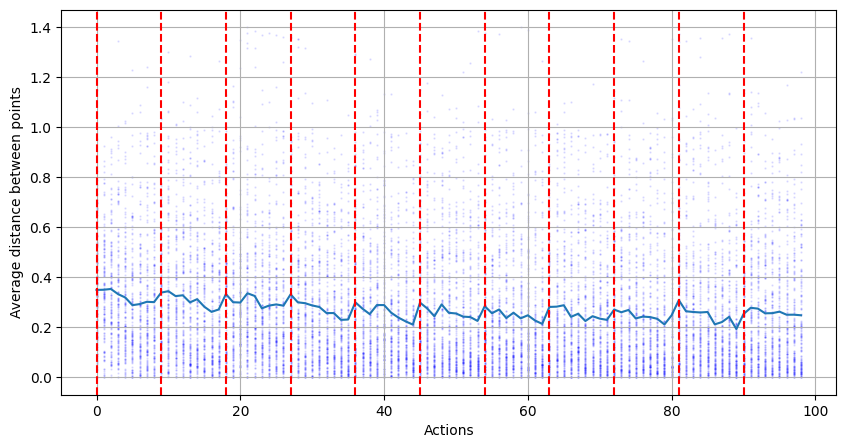

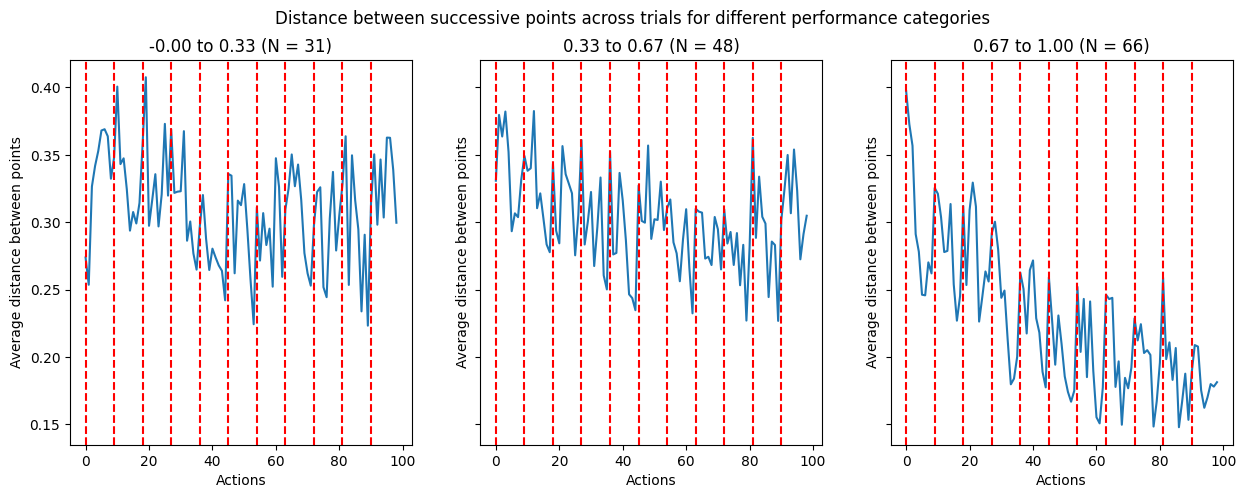

In [27]:
# Difference between raw points at times t and t+1
points = np.stack(subjects_df["raw_points"])
points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))

print(Nactions)

# Average distance between points :
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.grid()
for subj in range(Nsubj):
    ax.scatter(np.arange(flattened_distance[subj].size),flattened_distance[subj],c="b",alpha=0.1,s=0.5)
ax.plot(np.arange(flattened_distance[subj].size),np.mean(flattened_distance,axis=0))
for trial in range(Ntrials):
    ax.axvline(trial*(Nactions-1),linestyle="--",color="r")
ax.set_xlabel("Actions")
ax.set_ylabel("Average distance between points")


# Group by performances : 
Nsubcat = 3
fig,axs = plt.subplots(1,Nsubcat,figsize=(15,5),sharey=True)
fig.suptitle("Distance between successive points across trials for different performance categories")
perf = list(subjects_df["final_performance"])

perf_bins = np.linspace(0-1e-5,1+1e-5,Nsubcat+1)
category = np.digitize(perf,perf_bins) - 1
for score in range(Nsubcat):
    ax = axs[score]
    
    filtered_subjects = (category==score)
    filtered_metric = flattened_distance[filtered_subjects]
    avg_plot = np.mean(filtered_metric,axis=0)
        
    ax.plot(np.arange(avg_plot.shape[0]),avg_plot)
    for trial in range(Ntrials):
        ax.axvline(trial*(Nactions-1),linestyle="--",color="r")
    ax.set_xlabel("Actions")
    ax.set_ylabel("Average distance between points")
    ax.set_title("{:.2f} to {:.2f} (N = {})".format(perf_bins[score],perf_bins[score+1],filtered_metric.shape[0]))
    print(flattened_distance[filtered_subjects].shape)


The exploration / exploitation shift is clearly visible in the last category of subjects, with a distinct decrease in the average variation in point position. This is far less visible in less successful subject categories.

5352 negatives /10598 positives
4744 / 8306 remaining after removing edge actions


C:\Users\annic\AppData\Local\Temp\ipykernel_157920\945698760.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
C:\Users\annic\AppData\Local\Temp\ipykernel_157920\945698760.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


0 (np.float64(-1e-05), np.float64(0.33333))
1 (np.float64(0.33333), np.float64(0.6666700000000001))
2 (np.float64(0.6666700000000001), np.float64(1.00001))
0 (np.float64(-1e-05), np.float64(0.33333))
1 (np.float64(0.33333), np.float64(0.6666700000000001))
2 (np.float64(0.6666700000000001), np.float64(1.00001))
0 (np.float64(-1e-05), np.float64(0.33333))
1 (np.float64(0.33333), np.float64(0.6666700000000001))
2 (np.float64(0.6666700000000001), np.float64(1.00001))


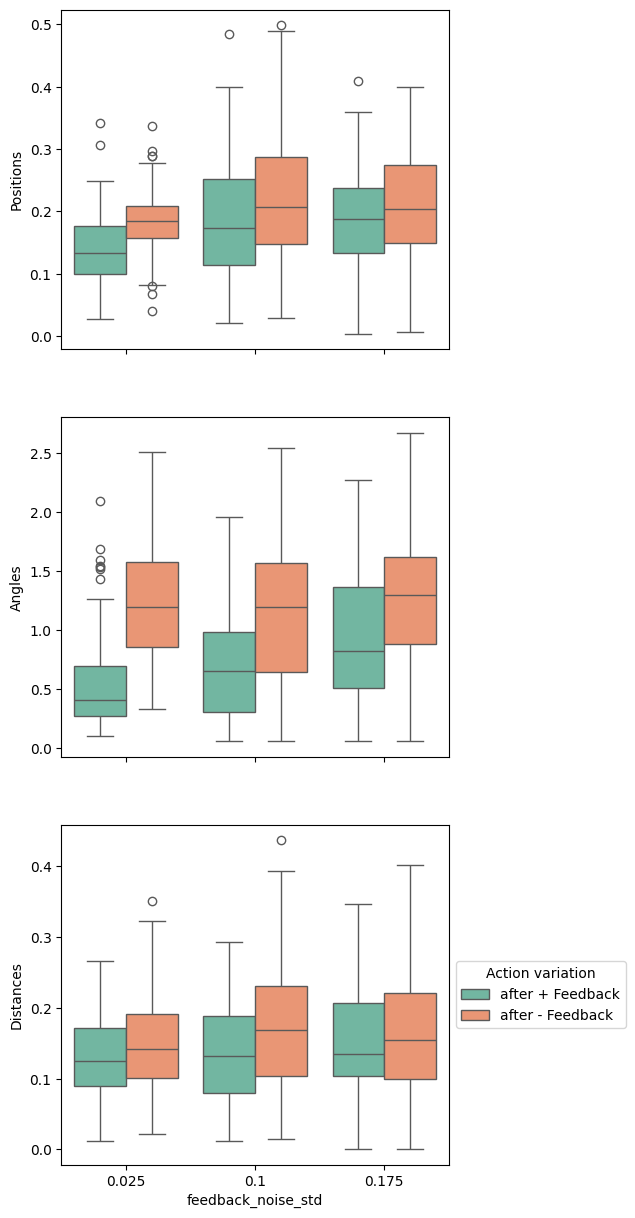

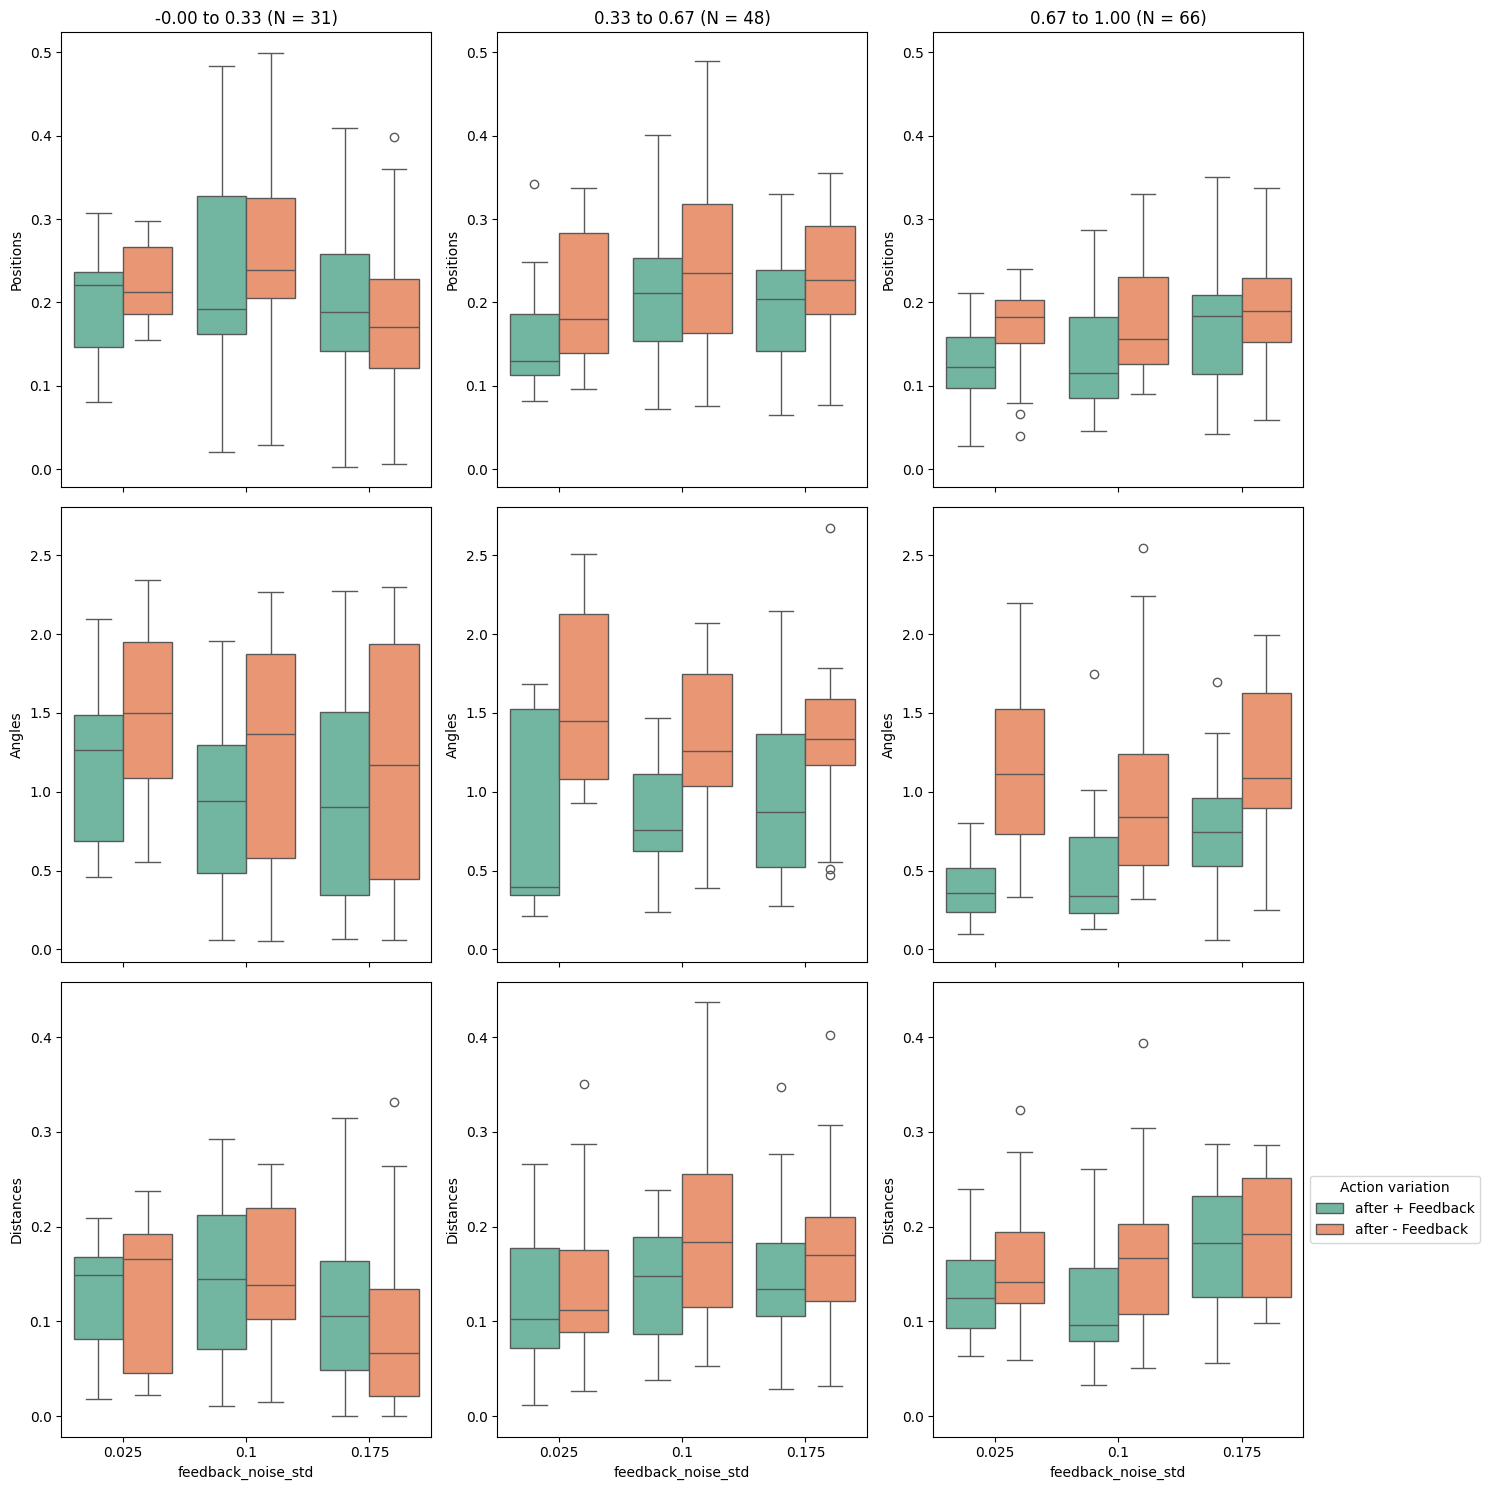

In [28]:

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0
delta_feedbacks = np.reshape(negative_feedbacks[:,:,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)

# np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,:-1] - all_angles[:,:,1:]

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,:-1] - all_distances[:,:,1:]

Nsubj = diff_barycenters.shape[0]
metrics_analyzed = [diff_barycenters,diff_angle,diff_distances]


fig,firstaxs = plt.subplots(3,1,figsize=(5,15),sharex=True)
for i,(metric,label) in enumerate(zip(metrics_analyzed,["Positions","Angles","Distances"])):
    ax = firstaxs[i]

    metric_analyzed = np.reshape(np.abs(metric[:,:-1,:]),(Nsubj,-1)) # Remove the last trial (there was no feedback)

    plot_df = subjects_df[['final_performance', 'feedback_noise_std']].copy()
    for subj in range(Nsubj):
        
        action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
        action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

        plot_df.loc[subj,"after + Feedback"] = np.mean(action_variation_after_positive_feedback)
        plot_df.loc[subj,"after - Feedback"] = np.mean(action_variation_after_negative_feedback)


    # Reshape the data to long format
    df_long = plot_df.melt(id_vars="feedback_noise_std", 
                    value_vars=["after + Feedback", "after - Feedback"], 
                    var_name="DataType", 
                    value_name=label)

    g = sns.boxplot(
        ax = ax,
        data=df_long,
        x="feedback_noise_std",       # Categories on the x-axis
        y=label,          # Scalar values for the boxplot
        hue="DataType",     # Differentiate data1 and data2 with colors
        palette="Set2"      # Color palette
    )
    ax.legend_.remove()
    
    # Add the legend to the figure
    plt.legend(
        title="Action variation",       # Legend title
        loc="center left",       # Adjust position relative to figure
        bbox_to_anchor=(1, 0.5)  # Position: (x, y)
    )
    
    
perf_bins = np.linspace(0-1e-5,1+1e-5,Nsubcat+1).astype(float)
performance_intervals = [(perf_bins[i],perf_bins[i+1]) for i in range(Nsubcat)]


category = np.digitize(perf,perf_bins) - 1   
    
    
# Differentiate between good performers and bad performers :
fig,axs = plt.subplots(3,3,figsize=(15,15),sharex=True)
for i,(metric,label) in enumerate(zip(metrics_analyzed,["Positions","Angles","Distances"])):
    
    axi = axs[i,0]
    metric_analyzed = np.reshape(np.abs(metric[:,:-1,:]),(Nsubj,-1)) # Remove the last trial (there was no feedback)
    
    for j,perf_interv in enumerate(performance_intervals):
        ax = axs[i,j]
        print(j,perf_interv)
        # print(metric_analyzed[delta_feedbacks].shape)
        # print(metric_analyzed[~delta_feedbacks].shape)


        plot_df = subjects_df[['final_performance', 'feedback_noise_std']].copy()        
        
        for subj in range(Nsubj):
            
            action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
            action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

            plot_df.loc[subj,"after + Feedback"] = np.mean(action_variation_after_positive_feedback)
            plot_df.loc[subj,"after - Feedback"] = np.mean(action_variation_after_negative_feedback)

        plot_df = plot_df[plot_df['final_performance'].between(*perf_interv)]

        # Reshape the data to long format
        df_long = plot_df.melt(id_vars="feedback_noise_std", 
                        value_vars=["after + Feedback", "after - Feedback"], 
                        var_name="DataType", 
                        value_name=label)
        g = sns.boxplot(
            ax = ax,
            data=df_long,
            x="feedback_noise_std",       # Categories on the x-axis
            y=label,          # Scalar values for the boxplot
            hue="DataType",     # Differentiate data1 and data2 with colors
            palette="Set2"      # Color palette
        )
        try :
            ax.legend_.remove()
        except:
            pass
        
        ax.sharey(firstaxs[i])
        # Remove y-label
        # ax.set_ylabel("")  # Empty string removes the y-label
        # # Remove y-ticks

        # ax.set_yticks([])  # Sets an empty list for y-ticks
        
        if i == 0:
            ax.set_title("{:.2f} to {:.2f} (N = {})".format(perf_interv[0],perf_interv[1],plot_df.shape[0]))
            
            
# Add the legend to the figure
plt.legend(
    title="Action variation",       # Legend title
    loc="center left",       # Adjust position relative to figure
    bbox_to_anchor=(1, 0.5)  # Position: (x, y)
)

fig.tight_layout()

Question : for a single action modality, how does the intensity of a variation relate to the variation of the other modalities.

5352 negatives /10598 positives
4744 / 8306 remaining after removing edge actions
(145, 11, 9)
(145, 11, 9)
(145, 11, 9)
(145, 99)
0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
     feedback_noise_std  final_performance  \
0                 0.100           1.000000   
1                 0.100           0.629516   
2                 0.100           0.520036   
3                 0.100           0.326501   
4                 0.100           0.964645   
..                  ...                ...   
140               0.175           0.561067   
141               0.175           0.790539   
142               0.175           0.775167   
143               0.175           0.206026   
144               0.175           0.929289   

                                                 Angle  \
0    [4.651083378651464, 0.14693018529021273, -1.59...   
1    [-1.357435725836416, 4.820579611521325, -2.526...   
2    [0.24275942408670367, -3.344637870843258, 0.02...   
3    [6.214256824489164, -1.5477432236108537, -3

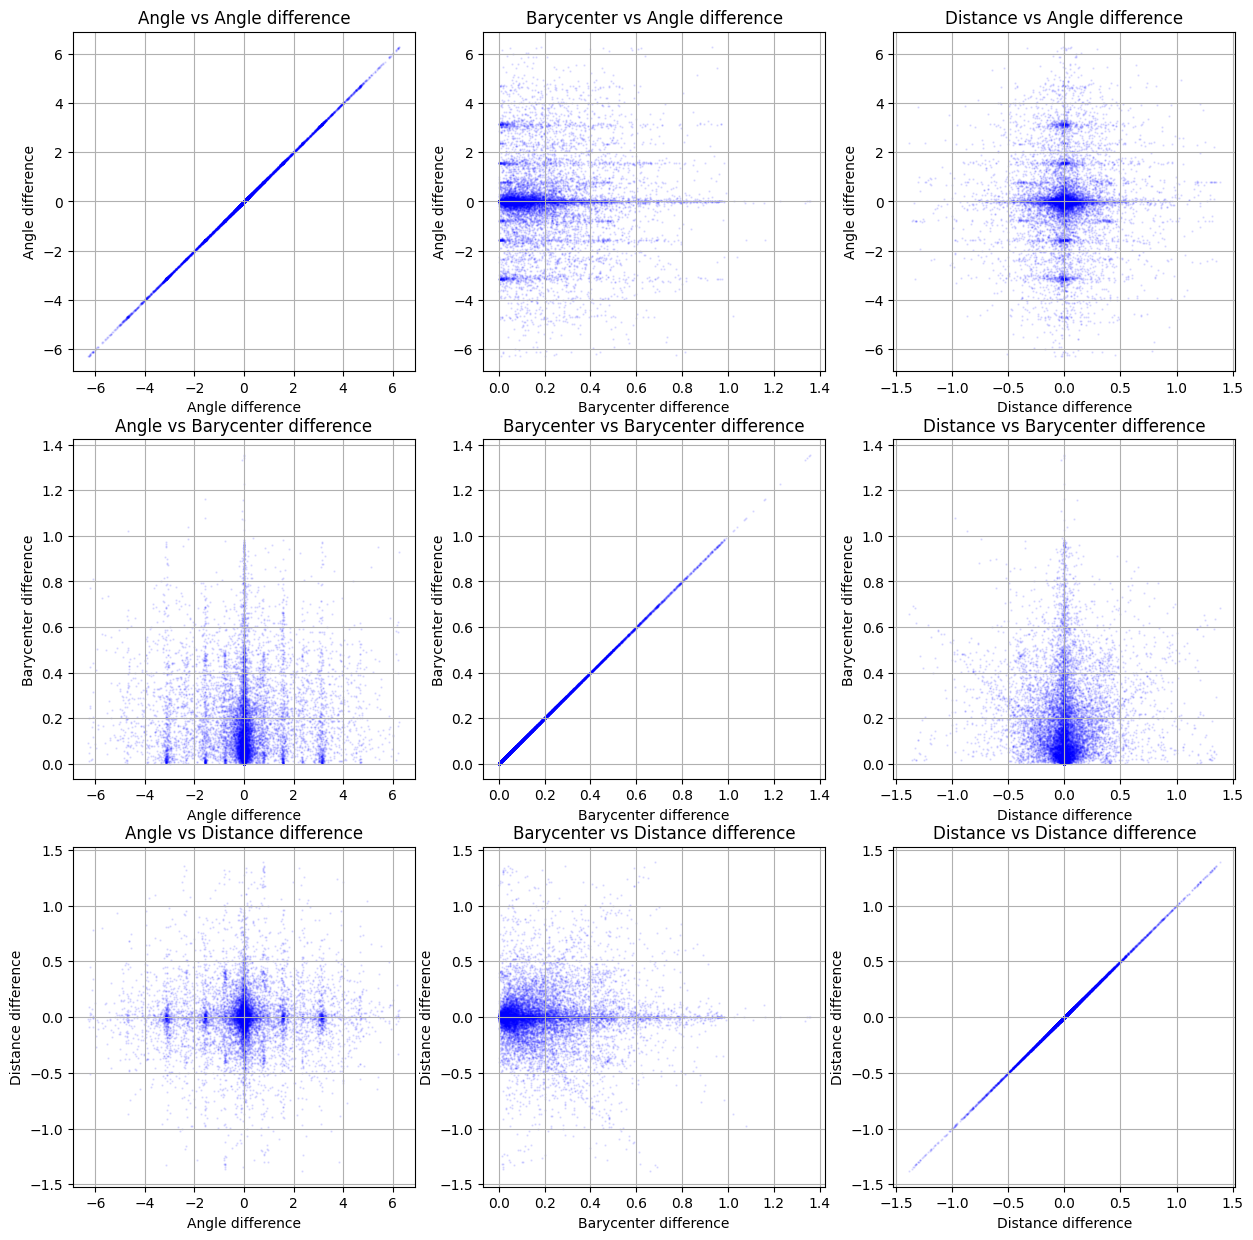

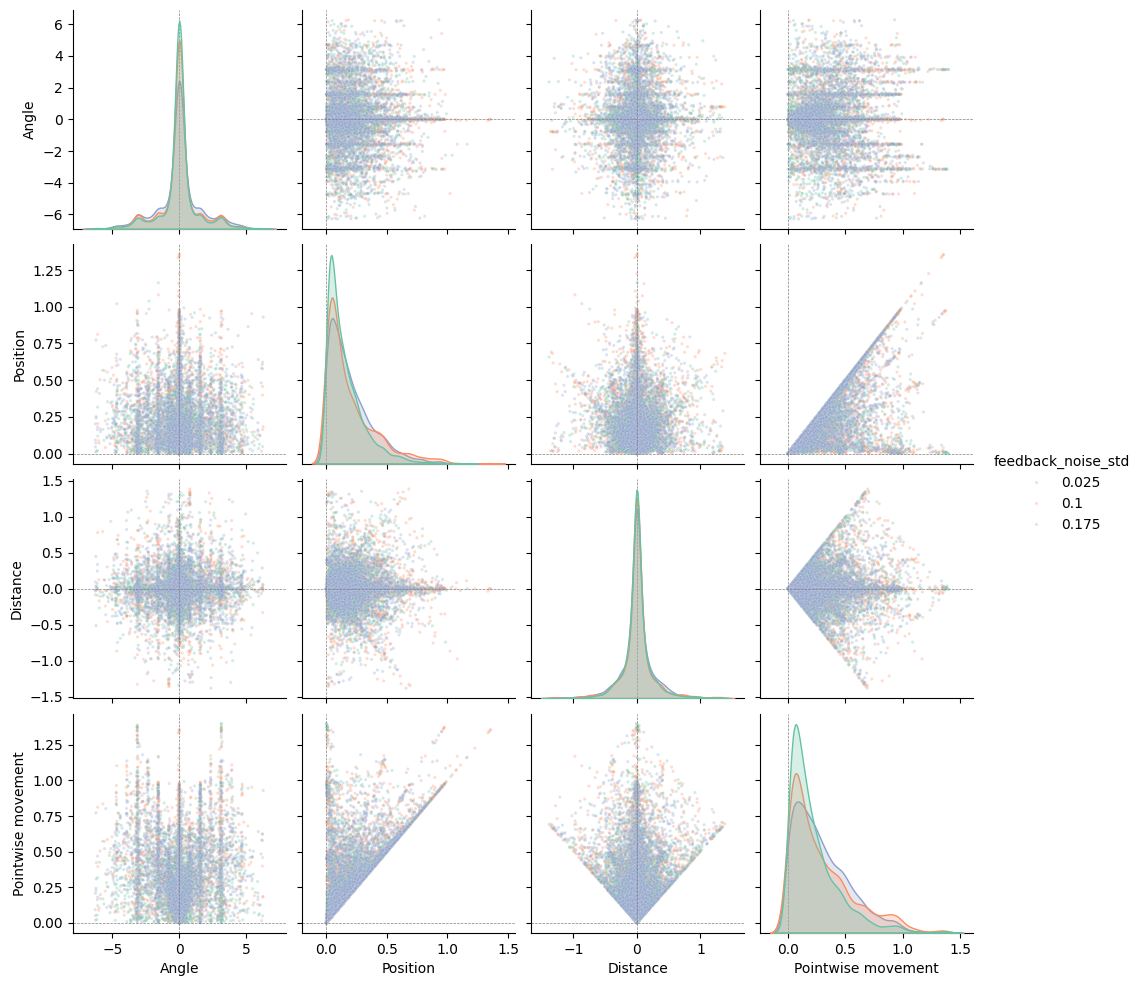

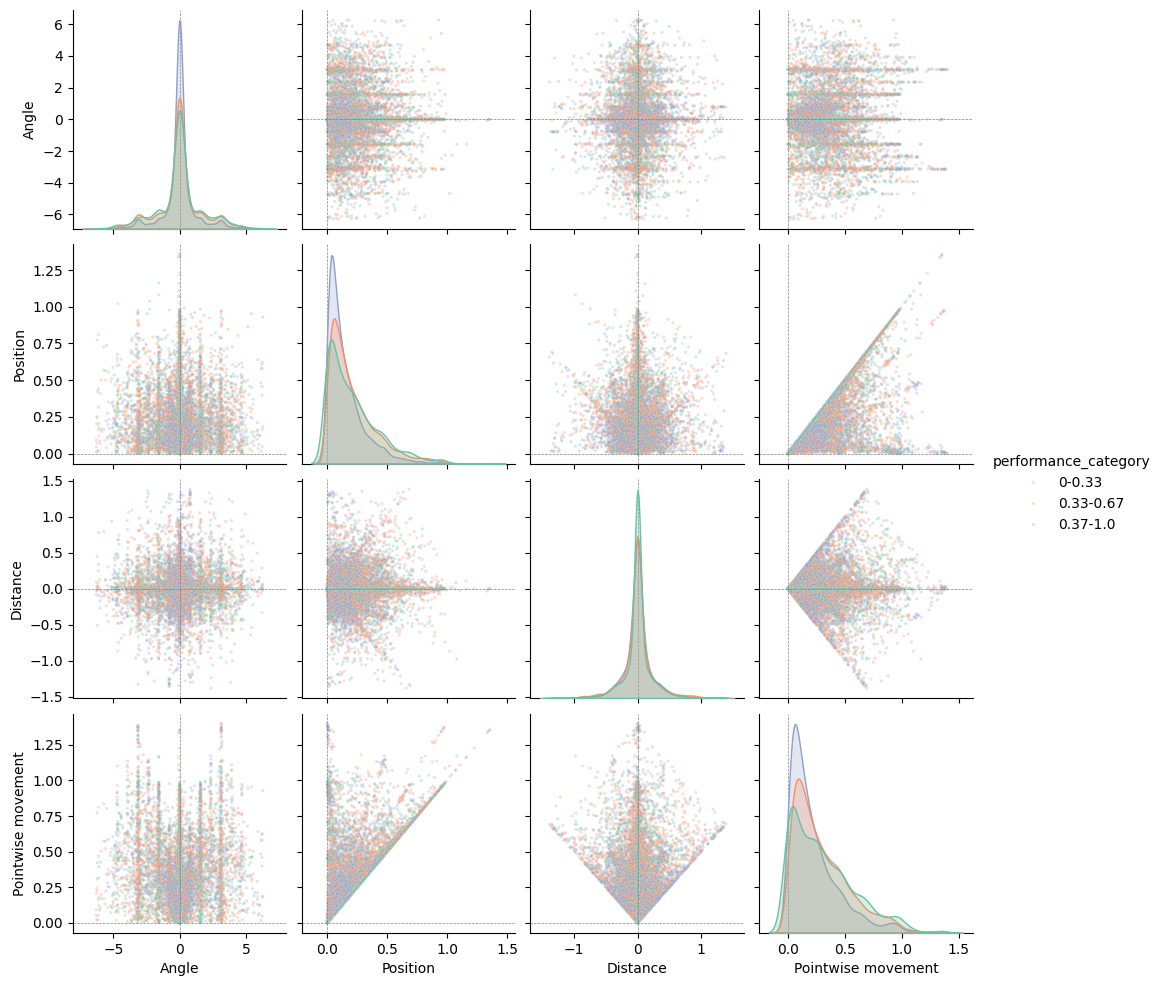

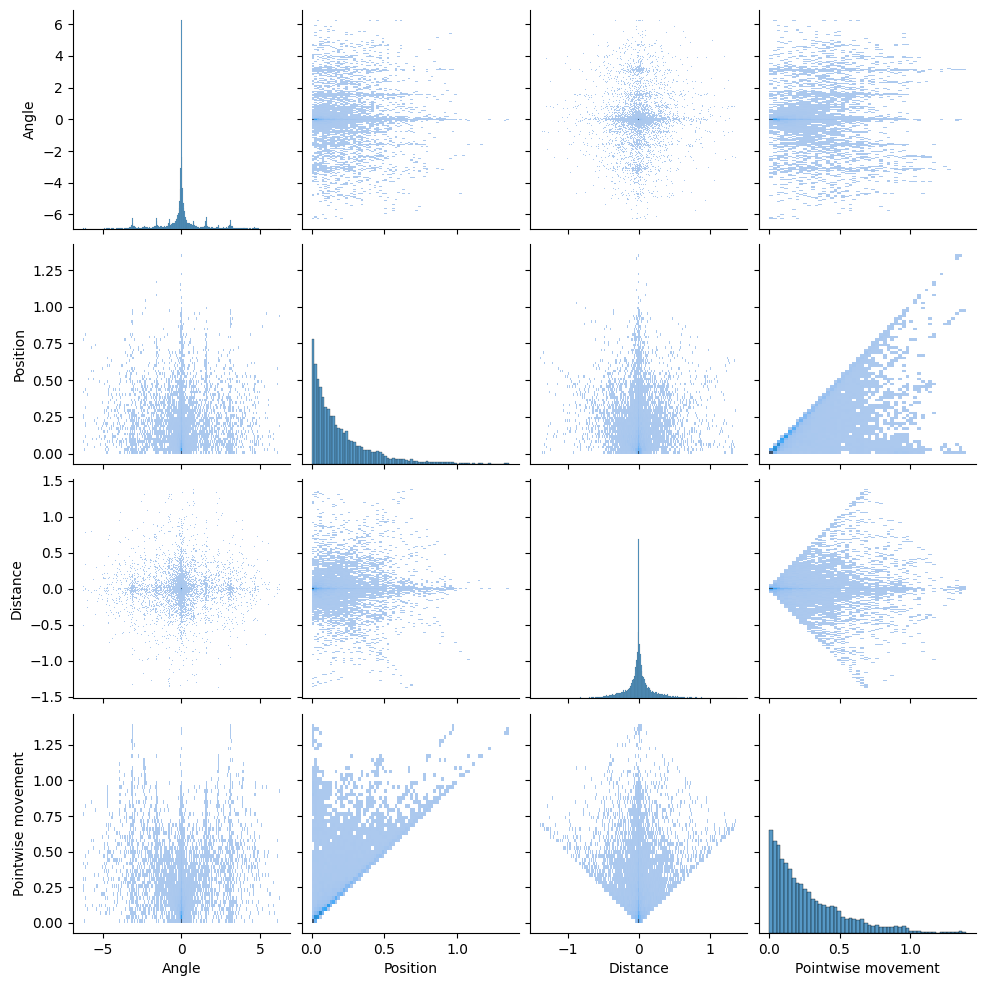

In [80]:
# Difference between raw points at times t and t+1
points = np.stack(subjects_df["raw_points"])
points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0


positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0
delta_feedbacks = np.reshape(negative_feedbacks[:,:,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)

# np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,:-1] - all_angles[:,:,1:]

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,:-1] - all_distances[:,:,1:]

Nsubj = diff_barycenters.shape[0]


print(diff_distances.shape)
print(diff_barycenters.shape)
print(diff_angle.shape)
print(flattened_distance.shape)


# Get the actions of interest :
diff_angle = np.reshape(diff_angle[:,:-1],(Nsubj,-1))
diff_barycenters = np.reshape(diff_barycenters[:,:-1],(Nsubj,-1))
diff_distances = np.reshape(diff_distances[:,:-1],(Nsubj,-1))
diff_points = np.reshape(avg_dist[:,:-1],(Nsubj,-1))

plot_these = list(zip([diff_angle,diff_barycenters,diff_distances],["Angle","Barycenter","Distance"]))   
fig,axs = plt.subplots(3,3,figsize=(15,15))
for xdim,(xmetric,xlabel) in enumerate(plot_these):
    for ydim,(ymetric,ylabel) in enumerate(plot_these):
        print(xdim,ydim)
        ax = axs[ydim,xdim]
        ax.grid()
        ax.set_xlabel("{} difference".format(xlabel))
        ax.set_ylabel("{} difference".format(ylabel))
       
        ax.set_title("{} vs {} difference".format(xlabel,ylabel))

        # for subj in range(Nsubj):
        ax.scatter(xmetric,ymetric,c="b",alpha=0.1,s=0.5)

# for subj in range(Nsubj):
#     plt.scatter(diff_angle[subj],diff_distances[subj],c="b",alpha=0.1,s=0.5)
# plt.show() 

# for subj in range(Nsubj):
#     plt.scatter(diff_angle[subj],diff_angle[subj],c="b",alpha=0.1,s=0.5)



plot_df = subjects_df[['feedback_noise_std','final_performance']].copy()



plot_df["Angle"] = list(diff_angle)
plot_df["Position"] = list(diff_barycenters)
plot_df["Distance"] = list(diff_distances)
plot_df["Points"] = list(diff_points)
plot_df['performance_category'] = pd.cut(plot_df['final_performance'], bins=np.linspace(0-1e-5,1+1e-5,4), labels=["0-0.33","0.33-0.67","0.37-1.0"], include_lowest=True)


# Create a new DataFrame with exploded rows
exploded_df = pd.DataFrame({
    'feedback_noise_std': np.repeat(plot_df['feedback_noise_std'], plot_df['Angle'].map(len)),
    "performance_category" : np.repeat(plot_df['performance_category'], plot_df['Angle'].map(len)),
    'Angle': np.concatenate(plot_df['Angle'].values),
    "Position": np.concatenate(plot_df['Position'].values),
    "Distance" : np.concatenate(plot_df['Distance'].values),
    "Pointwise movement" : np.concatenate(plot_df['Points'].values),
})


# plot_df = plot_df[plot_df['final_performance'].between(*perf_interv)]

print(plot_df)
print(exploded_df)

# # Reshape the data to long format
# df_long = plot_df.melt(id_vars="feedback_noise_std", 
#                 value_vars=["after + Feedback", "after - Feedback"], 
#                 var_name="DataType", 
#                 value_name=label)
# g = sns.boxplot(
#     ax = ax,
#     data=df_long,
#     x="feedback_noise_std",       # Categories on the x-axis
#     y=label,          # Scalar values for the boxplot
#     hue="DataType",     # Differentiate data1 and data2 with colors
#     palette="Set2"      # Color palette
# )
# # try :

g = sns.pairplot(exploded_df, hue="feedback_noise_std", palette="Set2", diag_kind="kde", height=2.5,
                diag_kws=dict(common_norm=False), plot_kws={'s': 5, 'alpha': 0.3})
    
for i,axline in enumerate(g.axes):
    for j, ax in enumerate(axline):
        ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
        if i != j :
            ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')
    
g = sns.pairplot(exploded_df[['performance_category','Angle','Position','Distance','Pointwise movement']], hue="performance_category", palette="Set2", diag_kind="kde", 
                 diag_kws=dict(common_norm=False), height=2.5,
                 plot_kws={'s': 5, 'alpha': 0.3})
for i,axline in enumerate(g.axes):
    for j, ax in enumerate(axline):
        ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
        if i != j :
            ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')
            
g = sns.pairplot(exploded_df[['performance_category','Angle','Position','Distance','Pointwise movement']], kind='hist')
# for i,axline in enumerate(g.axes):
#     for j, ax in enumerate(axline):
#         ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
#         if i != j :
#             ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')        

5352 negatives /10598 positives
4744 / 8306 remaining after removing edge actions
(145, 11, 9)
(145, 11, 9)
(145, 11, 9)
(145, 99)
     feedback_noise_std  final_performance  \
0                 0.100           1.000000   
1                 0.100           0.629516   
2                 0.100           0.520036   
3                 0.100           0.326501   
4                 0.100           0.964645   
..                  ...                ...   
140               0.175           0.561067   
141               0.175           0.790539   
142               0.175           0.775167   
143               0.175           0.206026   
144               0.175           0.929289   

                                                 Angle  \
0    [4.651083378651464, 0.14693018529021273, -1.59...   
1    [-1.357435725836416, 4.820579611521325, -2.526...   
2    [0.24275942408670367, -3.344637870843258, 0.02...   
3    [6.214256824489164, -1.5477432236108537, -3.86...   
4    [-0.07915345193033996

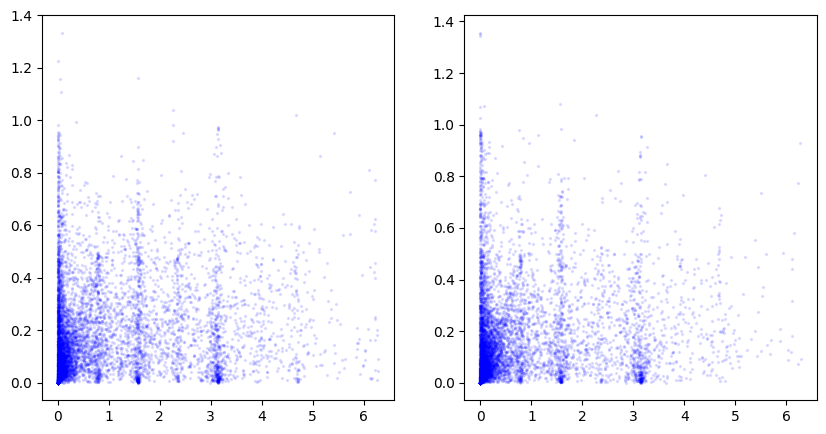

In [92]:
# Difference between raw points at times t and t+1
points = np.stack(subjects_df["raw_points"])
points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0


positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0
delta_feedbacks = np.reshape(negative_feedbacks[:,:,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)

# np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,:-1] - all_angles[:,:,1:]

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,:-1] - all_distances[:,:,1:]

Nsubj = diff_barycenters.shape[0]


print(diff_distances.shape)
print(diff_barycenters.shape)
print(diff_angle.shape)
print(flattened_distance.shape)


# Get the actions of interest :
diff_angle = np.reshape(np.abs(diff_angle[:,:-1]),(Nsubj,-1))
diff_barycenters = np.reshape(np.abs(diff_barycenters[:,:-1]),(Nsubj,-1))
diff_distances = np.reshape(np.abs(diff_distances[:,:-1]),(Nsubj,-1))
diff_points = np.reshape(np.abs(avg_dist[:,:-1]),(Nsubj,-1))

# plot_df = subjects_df[['feedback_noise_std','final_performance']].copy()
# plot_df["Angle"] = list(diff_angle)
# plot_df["Position"] = list(diff_barycenters)
# plot_df["Distance"] = list(diff_distances)
# plot_df["Points"] = list(diff_points)
# plot_df['performance_category'] = pd.cut(plot_df['final_performance'], bins=np.linspace(0-1e-5,1+1e-5,4), labels=["0-0.33","0.33-0.67","0.37-1.0"], include_lowest=True)


# plot_df = plot_df[plot_df['final_performance'].between(*perf_interv)]

print(plot_df)
print(exploded_df)
fig,axs = plt.subplots(1,2,figsize=(10,5))
window = 50
for subj in range(Nsubj):
    axs[0].scatter(diff_angle[subj][:window],diff_barycenters[subj][:window],alpha=0.1,s=2,color='blue')
    axs[1].scatter(diff_angle[subj][-window:],diff_barycenters[subj][-window:],alpha=0.1,s=2,color='blue')